In [287]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

clinical_df = pd.read_csv('clinical.tsv', sep='\t')

clinical_df['status_strat'] = np.where(clinical_df['days_to_death'].replace("'--", np.NaN).apply(pd.to_numeric) < 430, 0, np.where(clinical_df['days_to_death'].replace("'--", np.NaN).apply(pd.to_numeric) >= 430, 1, 2))
clinical_df['stage_m_strat'] = clinical_df['ajcc_clinical_m']clinical_df['stage_m_strat'] = clinical_df['ajcc_pathologic_m'].map({'M0' : 0, 'MX' : 1})
clinical_df['stage_n_strat'] = clinical_df['ajcc_clinical_n'].replace("'--", np.NaN).map({'NX' : 0, 'N0' : 1, 'N1' : 2, 'N2' : 3, 'N2a' : 3, 'N2b' : 3, 'N2c' : 3, 'N3' : 4})
clinical_df['stage_strat'] = clinical_df['ajcc_clinical_stage'].replace("'--", np.NaN).map({'Stage I' : 0, 'Stage II' : 1, 'Stage III' : 2, 'Stage IVA' : 3, 'Stage IVB' : 3, 'Stage IVC' : 3})
clinical_df['stage_t_strat'] = clinical_df['ajcc_clinical_t'].replace("'--", np.NaN).map({'TX' : 0, 'T0' : 1, 'T1' : 2, 'T2' : 3, 'T3' : 4, 'T4' : 5, 'T4a' : 5, 'T4b' : 5})
clinical_df['diag_strat'] = clinical_df['morphology'].replace("'--", np.NaN).map({'8070/3' : 0, '8071/3' : 1, '8072/3' : 2, '8074/3' : 3, '8083/3' : 4})

clinical_df = clinical_df[list(set(clinical_df.columns) & set(['case_id', 'status_strat', 'stage_m_strat', 'stage_n_strat', 'stage_strat', 'stage_t_strat', 'diag_strat']))]

#df = pd.read_csv('rnaseq_all.tsv', sep='\t')
#df = pd.read_csv('rnaseq_s1.tsv', sep='\t')
df = pd.read_csv('rnaseq_s1_s2.tsv', sep='\t')
df = pd.merge(df, pd.read_csv('file_to_case.tsv', sep='\t'), on='file_id', how='left')
df = pd.merge(df, clinical_df, on='case_id', how='left')

df = df.drop(columns=['file_id', 'case_id'])

# Classification

In [288]:
for target in ['status_strat', 'stage_m_strat', 'stage_n_strat', 'stage_strat', 'stage_t_strat', 'diag_strat']:
    df1 = pd.concat([df.iloc[:, :-6], df[target]], axis=1).dropna()
    X = df1.iloc[:, :-1]
    y = df1.iloc[:, -1]

    from sklearn.preprocessing import MinMaxScaler
    X = MinMaxScaler().fit_transform(X)

    from sklearn.model_selection import cross_val_score
    from sklearn.ensemble import RandomForestClassifier
    print(target)
    print(cross_val_score(RandomForestClassifier(), X, y, cv=6, scoring='f1_micro'))

status_strat
[0.57446809 0.57446809 0.56382979 0.54255319 0.54255319 0.53191489]
stage_m_strat
[0.94680851 0.95698925 0.95698925 0.95698925 0.95698925 0.94623656]
stage_n_strat
[0.5106383  0.4787234  0.49462366 0.49462366 0.55913978 0.5483871 ]
stage_strat
[0.54347826 0.54347826 0.52173913 0.52173913 0.54945055 0.53846154]
stage_t_strat
[0.35106383 0.36170213 0.23655914 0.33333333 0.49462366 0.35483871]
diag_strat


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(


[0.85106383 0.86170213 0.86170213 0.86170213 0.85106383 0.85106383]


In [283]:
for target in ['status_strat', 'stage_m_strat', 'stage_n_strat', 'stage_strat', 'stage_t_strat', 'diag_strat']:
    df1 = pd.concat([df.iloc[:, :-6], df[target]], axis=1).dropna()
    X = df1.iloc[:, :-1]
    y = df1.iloc[:, -1]

    from sklearn.preprocessing import MinMaxScaler
    X = MinMaxScaler().fit_transform(X)

    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import f1_score
    classifier = RandomForestClassifier()
    classifier.fit(X_train, y_train)
    print(target)
    print(f1_score(y_test, classifier.predict(X_test), average='micro'))

status_strat
0.631578947368421
stage_m_strat
0.8076923076923077
stage_n_strat
0.37037037037037035
stage_strat
0.5102040816326531
stage_t_strat
0.38181818181818183
diag_strat
0.9122807017543859


# Dimensionality Rediction

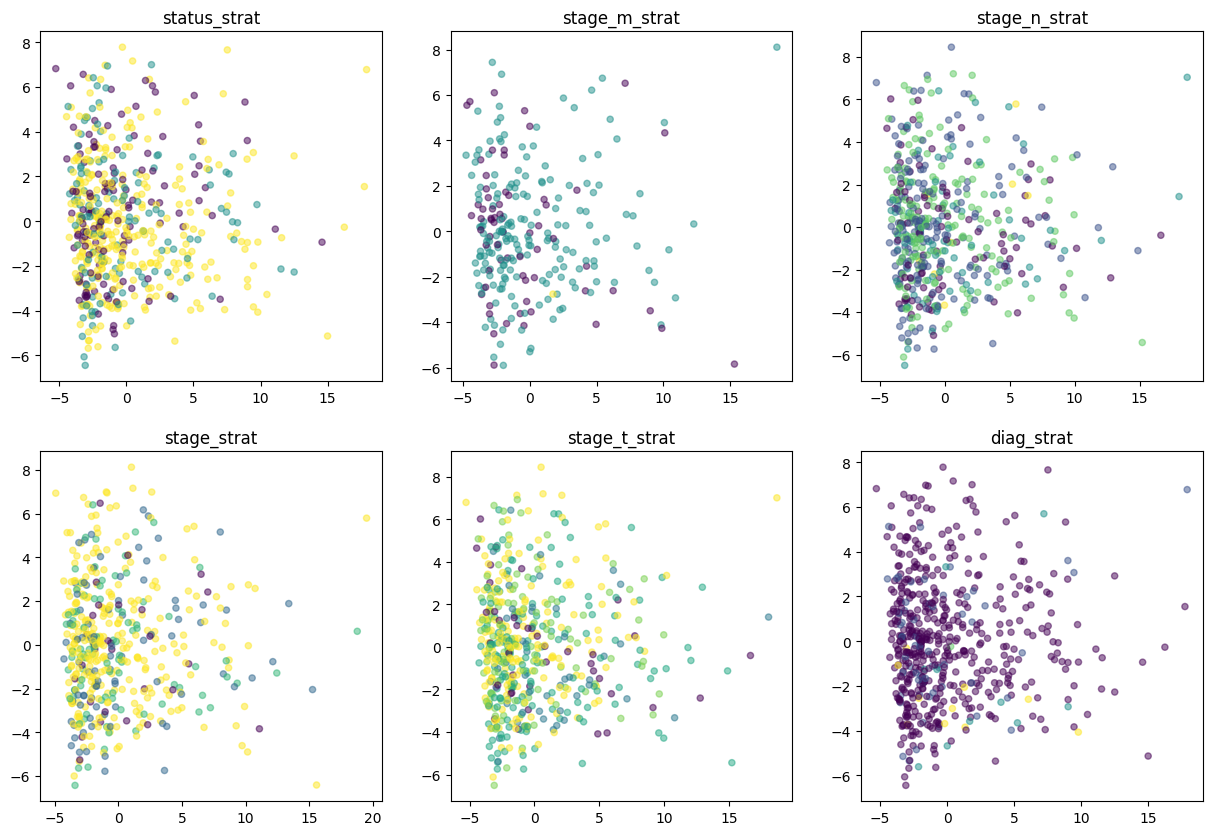

In [273]:
plt.figure(figsize = (15, 10))
for i, target in enumerate(['status_strat', 'stage_m_strat', 'stage_n_strat', 'stage_strat', 'stage_t_strat', 'diag_strat']):
    df1 = pd.concat([df.iloc[:, :-6], df[target]], axis=1).dropna()
    X = df1.iloc[:, :-1]
    y = df1.iloc[:, -1]

    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    principal_components = PCA(n_components=2).fit_transform(StandardScaler().fit_transform(X))
    principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

    plt.subplot(231 + i)
    plt.title(target)
    plt.scatter(principal_df['PC1'], principal_df['PC2'], c=y, cmap='viridis', s=20, alpha=0.5)
plt.show()

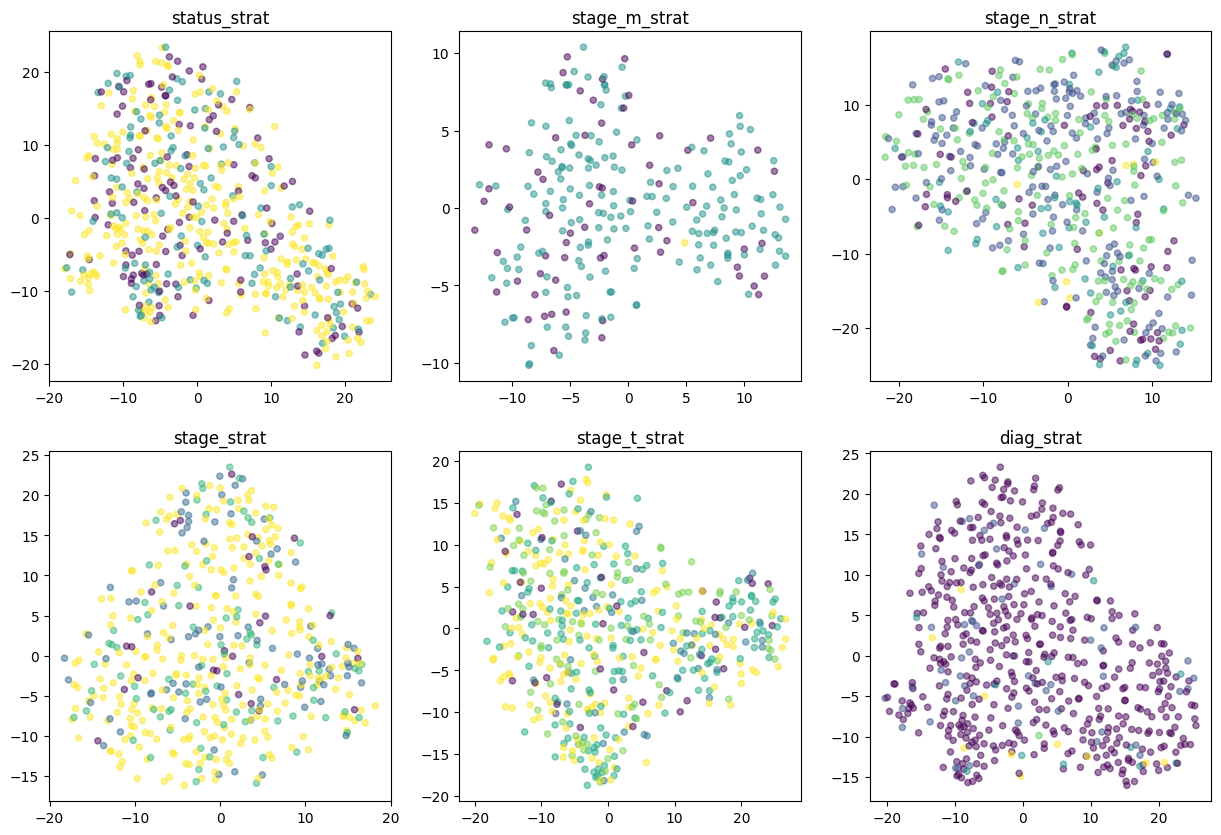

In [274]:
plt.figure(figsize = (15, 10))
for i, target in enumerate(['status_strat', 'stage_m_strat', 'stage_n_strat', 'stage_strat', 'stage_t_strat', 'diag_strat']):
    df1 = pd.concat([df.iloc[:, :-6], df[target]], axis=1).dropna()
    X = df1.iloc[:, :-1]
    y = df1.iloc[:, -1]

    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE
    tsne = TSNE(n_components=2).fit_transform(StandardScaler().fit_transform(X))
    tsne_df = pd.DataFrame(data=tsne, columns=['PC1', 'PC2'])

    plt.subplot(231 + i)
    plt.title(target)
    plt.scatter(tsne_df['PC1'], tsne_df['PC2'], c=y, cmap='viridis', s=20, alpha=0.5)
plt.show()

# Autoencoders

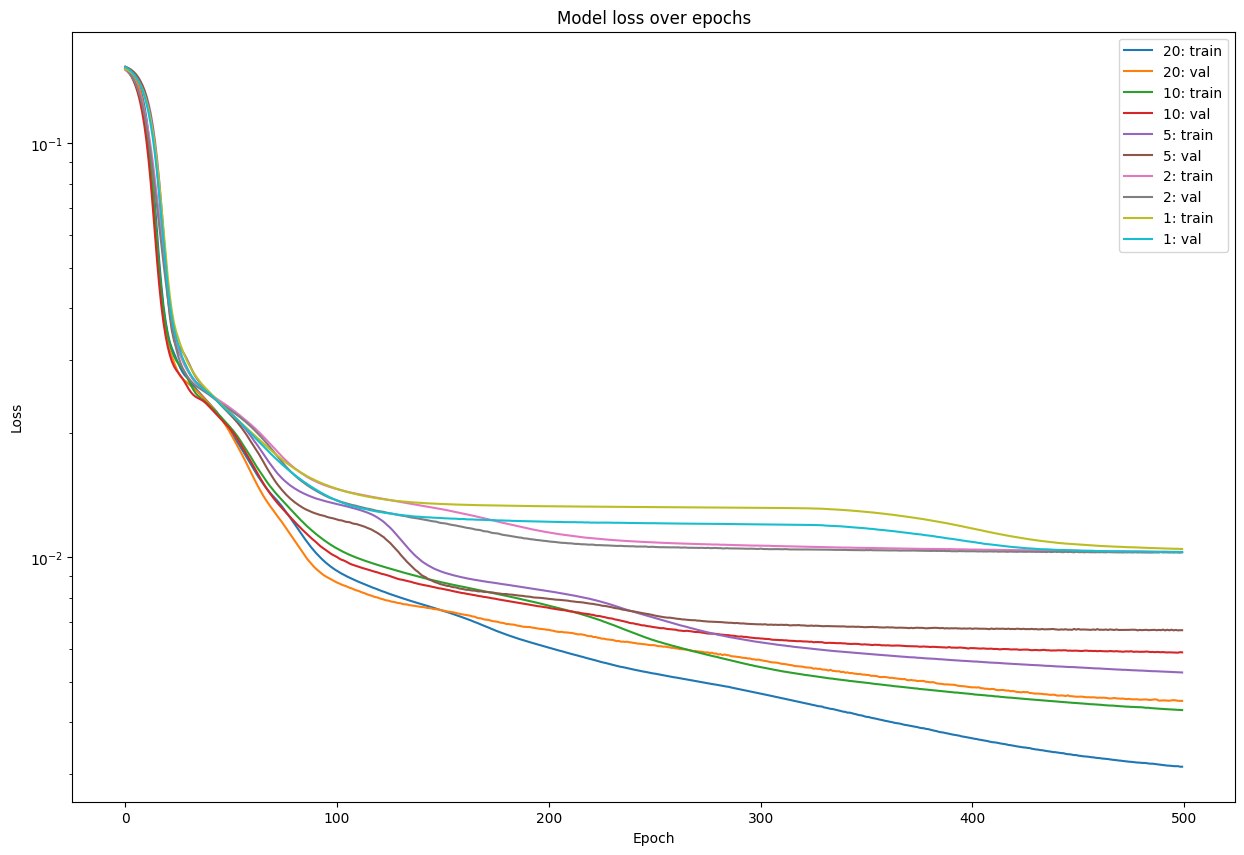

In [278]:
plt.figure(figsize = (15, 10))
for l in [20, 10, 5, 2, 1]:
    target = 'diag_strat'
    df1 = pd.concat([df.iloc[:, :-6], df[target]], axis=1).dropna()
    X = df1.iloc[:, :-1]
    y = df1.iloc[:, -1]

    from sklearn.preprocessing import MinMaxScaler
    X = MinMaxScaler().fit_transform(X)

    from keras.layers import Input, Dense
    input_img = Input(shape=(X.shape[1],))
    encoded = Dense(X.shape[1], activation='relu')(input_img)
    encoded = Dense(X.shape[1], activation='relu')(encoded)
    encoded = Dense(l, activation='relu')(encoded)
    decoded = Dense(X.shape[1], activation='relu')(encoded)
    decoded = Dense(X.shape[1], activation='relu')(decoded)
    decoded = Dense(X.shape[1], activation='sigmoid')(decoded)

    from keras.models import Model
    autoencoder = Model(input_img, decoded)
    encoder = Model(input_img, encoded)
    decoder = Model(encoded, decoded)

    autoencoder.compile(optimizer='adam', loss='mean_squared_error')

    history = autoencoder.fit(X, X, epochs=500, batch_size=256, validation_split=0.2, verbose=0)

    plt.plot(history.history['loss'], label= str(l) + ': train')
    plt.plot(history.history['val_loss'], label=str(l) + ': val')
plt.title('Model loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.show()

In [284]:
for l in [20, 10, 5, 2, 1]:
    target = 'diag_strat'
    df1 = pd.concat([df.iloc[:, :-6], df[target]], axis=1).dropna()
    X = df1.iloc[:, :-1]
    y = df1.iloc[:, -1]

    from sklearn.preprocessing import MinMaxScaler
    X = MinMaxScaler().fit_transform(X)

    from keras.layers import Input, Dense
    input_img = Input(shape=(X.shape[1],))
    encoded = Dense(X.shape[1], activation='relu')(input_img)
    encoded = Dense(X.shape[1], activation='relu')(encoded)
    encoded = Dense(l, activation='relu')(encoded)
    decoded = Dense(X.shape[1], activation='relu')(encoded)
    decoded = Dense(X.shape[1], activation='relu')(decoded)
    decoded = Dense(X.shape[1], activation='sigmoid')(decoded)

    from keras.models import Model
    autoencoder = Model(input_img, decoded)
    encoder = Model(input_img, encoded)
    decoder = Model(encoded, decoded)

    autoencoder.compile(optimizer='adam', loss='mean_squared_error')

    history = autoencoder.fit(X, X, epochs=500, batch_size=256, validation_split=0.2, verbose=0)
    encoded_imgs = encoder.predict(X)

    from sklearn.preprocessing import MinMaxScaler
    X = MinMaxScaler().fit_transform(encoded_imgs)

    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import f1_score
    classifier = RandomForestClassifier()
    classifier.fit(X_train, y_train)
    print(target)
    print(f1_score(y_test, classifier.predict(X_test), average='micro'))

18/18 [==============================] - 0s 312us/step
diag_strat
0.8596491228070176
18/18 [==============================] - 0s 335us/step
diag_strat
0.9122807017543859
18/18 [==============================] - 0s 311us/step
diag_strat
0.8245614035087719
18/18 [==============================] - 0s 324us/step
diag_strat
0.8947368421052632
18/18 [==============================] - 0s 363us/step
diag_strat
0.7543859649122807
